In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as T
from torch.distributions import Categorical
from IPython import display as ipythondisplay
import imageio

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible = 0, size = (400, 300))
display.start()

### Environment

In [ ]:
env = gym.make('Acrobot-v1').unwrapped

print(env.action_space.n)
print(env.observation_space)

3
Box(-28.274333953857422, 28.274333953857422, (6,), float32)


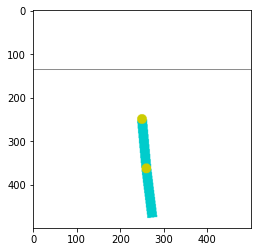

In [ ]:
env.reset()
screen = env.render(mode = 'rgb_array')
plt.imshow(screen)

Tesla V100-SXM2-16GB


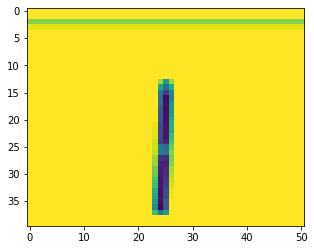

torch.Size([1, 40, 51])


In [ ]:
# ref: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))

resize = T.Compose([T.ToPILImage(), T.Grayscale(), T.Resize(40, interpolation = Image.BICUBIC), T.ToTensor()])

def get_screen(env):
    screen = env.render(mode = 'rgb_array')
    screen = screen.transpose((2, 0, 1))
    screen = screen[:, 110:, :]
    screen = np.ascontiguousarray(screen, dtype = np.float32) / 255
    screen = torch.from_numpy(screen)
    
    return resize(screen).to(device)

env.reset()
plt.figure()
plt.imshow(get_screen(env).cpu().squeeze(0).numpy(), interpolation = 'none')
plt.show()

print(get_screen(env).size())

### Actor and Critic Networks

In [ ]:
class Net(nn.Module):
    def __init__(self, h, w, outputs):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(4, 16, kernel_size = 3, stride = 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, stride = 2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 5, stride = 2)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size = 5, stride = 2)
        self.bn4 = nn.BatchNorm2d(64)

        conv2d_size_out = lambda size, kernel_size = 3, pad = 0, stride = 2 : (size + (2 * pad) - kernel_size) // stride  + 1

        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(conv2d_size_out(w, stride = 1)), kernel_size = 5), kernel_size = 5)
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(conv2d_size_out(h, stride = 1)), kernel_size = 5), kernel_size = 5)
        flatten_input_size = convw * convh * 64
        print(flatten_input_size)
        self.fc1 = nn.Linear(flatten_input_size, 128)
        self.fc2 = nn.Linear(128, outputs)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.fc1(x.view(x.size(0), -1)))
        x = self.fc2(x)
        return F.softmax(x, -1)
  

### **TD Actor Critic Agent**

In [ ]:
class Agent:
    def __init__(self, env, lr = 0.001, gamma = 0.9):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        self.gamma = gamma

        _, h, w = get_screen(env).size()
        self.actor = Net(h, w, self.action_space.n).to(device)
        self.critic = Net(h, w, 1).to(device)

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr = 0.0001)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr = 0.001)

        self.critic_criterion = nn.SmoothL1Loss()

    # ref: https://pytorch.org/docs/stable/distributions.html
    def step(self, state):
        probs = self.actor(state)
        state_val = self.critic(state)
        m = Categorical(probs)
        action = m.sample()
        log_prob = m.log_prob(action)
        return action, log_prob, state_val

    def calculate_returns(self, rewards):
        returns = []
        curr = 0
        for r in reversed(rewards):
            curr = r + self.gamma * curr
            returns.append(curr)
        return torch.tensor(returns[::-1])
    
    def update(self, values, log_probs, rewards):
        returns = self.calculate_returns(rewards)
        returns = (returns - returns.mean()) / returns.std()
        actor_loss = []
        critic_loss = []

        for value, log_prob, R in zip(values, log_probs, returns):
            advantage = R - value.item()
            # Actor loss
            actor_loss.append(-1 * log_prob * advantage)
            # Crtic loss
            critic_loss.append(self.critic_criterion(torch.tensor([R], device = device).unsqueeze(1), value).unsqueeze(0))

        # Actor loss backprop
        self.actor_optimizer.zero_grad()
        actor_loss = torch.cat(actor_loss).sum()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Critic loss backprop
        self.critic_optimizer.zero_grad()
        critic_loss = torch.cat(critic_loss).sum()
        critic_loss.backward()
        self.critic_optimizer.step()

    def test(self):
        self.env.reset()
        images = []
        images.append(self.env.render(mode = 'rgb_array'))
        last_screen = get_screen(self.env)
        state = torch.cat([last_screen, last_screen, last_screen, last_screen]).unsqueeze(0)
        done = False
        i = 0
        while not done and i < 10000:
            with torch.no_grad():
                action = self.actor(state).max(1)[1].view(1, 1)
            _, reward, done, info = self.env.step(action.item())
            images.append(self.env.render(mode = 'rgb_array'))
            next_screen = get_screen(self.env)
            next_state = torch.cat((state[:, 1:, :, :], next_screen.unsqueeze(0)), dim = 1)
            state = next_state
            i += 1
        
        imageio.mimsave('result_acrobot.gif', images, fps = 30)
        return images

    def saveWeights(self, path):
        torch.save(self.actor.state_dict(), path + '_actor')
        torch.save(self.critic.state_dict(), path + '_critic')

    def loadWeights(self, path):
        self.actor.load_state_dict(torch.load(path + '_actor'))
        self.critic.load_state_dict(torch.load(path + '_critic'))


### MDP

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
agent = Agent(env)

total_rewards = []

best = float('-inf')
episode = 0
while True:
    env.reset()
    done = False

    state_values = []
    log_probs = []
    rewards = []

    last_screen = get_screen(env)
    # stacking last 4 screens together as state
    state = torch.cat([last_screen, last_screen, last_screen, last_screen]).unsqueeze(0)
    curr_reward = 0
    i = 0
    while not done and i < 10000:
        action, log_prob, state_val = agent.step(state)
        state_values.append(state_val)
        log_probs.append(log_prob)
        _, reward, done, info = env.step(action.item())
        curr_reward += reward
        rewards.append(reward)
        next_screen = get_screen(env)

        if done:
            next_state = None
        else:
            next_state = torch.cat((state[:, 1:, :, :], next_screen.unsqueeze(0)), dim = 1)

        state = next_state
        i += 1
    
    agent.update(state_values, log_probs, rewards)

    total_rewards.append(curr_reward)
    avg_rewards = np.mean(total_rewards[-50:])

    if (episode + 1) % 10 == 0:
        print(f'{episode + 1} episode completed. Rewards: {avg_rewards}')
        # saving the best weight
        if avg_rewards > best:
            best = avg_rewards
            agent.saveWeights('/content/drive/MyDrive/RL/3/AC_Acrobot')
        
        
    episode += 1
    torch.cuda.empty_cache()

    if avg_rewards >= env.spec.reward_threshold or episode > 1200:
        break

print('Complete')

384
384
50 episode completed.
100 episode completed.
150 episode completed.
200 episode completed.
250 episode completed.
300 episode completed.
350 episode completed.
400 episode completed.
450 episode completed.
500 episode completed.
550 episode completed.
600 episode completed.
650 episode completed.
700 episode completed.
750 episode completed.
800 episode completed.
850 episode completed.
900 episode completed.
950 episode completed.
1000 episode completed.
1050 episode completed.
1100 episode completed.
1150 episode completed.
1200 episode completed.
Complete


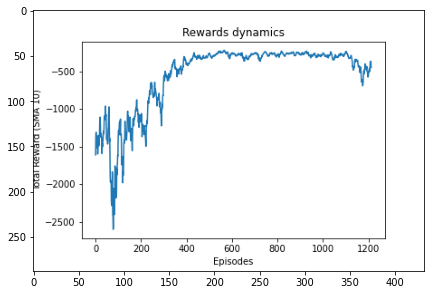

In [ ]:
Plotting Total rewards received vs Episodes
step = 10
plt.title('Rewards dynamics')
plt.xlabel('Episodes')
plt.ylabel('Total Reward (SMA 10)')
plt.plot([np.mean(total_rewards[i : i + step]) for i in range(len(total_rewards))])
plt.savefig('Rewards_dynamics.png')


In [ ]:
agent.saveWeights('AC_Acrobot')

In [ ]:
agent = Agent(env)
agent.loadWeights('AC_Acrobot')
imgs = agent.test()
len(imgs)

384
384


181